<a href="https://colab.research.google.com/github/MarcAssmann/morse_training/blob/main/train_morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Model to train Morse discriminator** 
22/05/20



# Neuer Abschnitt

In [3]:
!git clone https://github.com/MarcAssmann/morse_training.git

fatal: destination path 'morse_training' already exists and is not an empty directory.


In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

(1) Process Data from Morse Generator

In [5]:
file = 'morse_training/platformio-device-monitor-210516-161118-cleaned.log'
pd.read_csv(file)

,R,G,B,Character
0,0,0,0,
1,39,38,30,
2,39,38,30,
3,39,38,30,
4,39,38,30,
...,...,...,...,...
79797,143,148,163,N
79798,143,130,102,N
79799,143,129,96,N
79800,144,149,163,N


In [6]:
data = pd.read_csv(file)
X = data[['B']]
y = data[['Character']]
y = y.replace(' ', '_')

In [7]:
y['Character'][1]

'_'

In [8]:
# taken from https://stackoverflow.com/questions/43618245/how-to-one-hot-encode-sentences-at-the-character-level
def one_hot(c: str):
  idxs = np.fromstring(c, dtype=np.uint8) - ord('A')
  one_hot = tf.one_hot(idxs, 31, dtype=tf.uint8)
  one_hot = one_hot.numpy().tolist()[0]
  return one_hot

one_hot_mapping = {}

for i in range(ord('A'),ord('_')+1):
  c = chr(i)
  one_hot_mapping[c] = one_hot(c)

y_irgendwas = [ one_hot_mapping[c] for c in y['Character']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


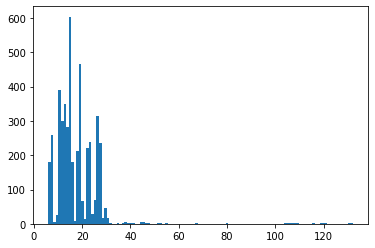

In [9]:
# Only keep sequences smaller 30 (try to throw away double characters)
last_character = y_irgendwas[0]
single_sequence = []

X_data = []
y_data = []

for i in range(len(y_irgendwas)):
  # if y_irgendwas[i] != one_hot_mapping["_"]:

  if y_irgendwas[i] == last_character:
    single_sequence.append(X['B'][i])

  else:
    if single_sequence:
      X_data.append(single_sequence)
      y_data.append(last_character)
    
    single_sequence = [X['B'][i]]
  
  last_character = y_irgendwas[i]

len(X_data), len(y_data)
plt.hist(list(map(len, X_data)), bins= 120)

mask = [ key for key,val in enumerate(X_data) if len(val)<30 ]  

y_data = [ y_data[val] for val in mask]
X_data = [ X_data[val] for val in mask]

In [10]:
# padde X_data sequences

def pad_sequence(sequence, pad_length = 30):
  if len(sequence) == pad_length:
    return sequence
  if len(sequence) > pad_length:
    return sequence[:pad_length]
  else:
    return sequence + [0]*(pad_length-len(sequence))

X_data = [ pad_sequence(seq) for seq in X_data]


In [11]:
X_tensor = tf.convert_to_tensor(X_data)
y_tensor = tf.convert_to_tensor(y_data)


In [12]:
length = len(X_tensor)

X_train = X_tensor[:int(0.6*length)]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_val = X_tensor[int(0.6*length):int(0.8*length)]
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

X_test = X_tensor[int(0.8*length):]
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_tensor[:int(0.6*length)]
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))

y_val = y_tensor[int(0.6*length):int(0.8*length)]
y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1]))

y_test = y_tensor[int(0.8*length):]
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [13]:
print(X_train.shape, ',', X_train.ndim, ',', type(X_train))
print(y_train.shape, ',', y_train.ndim, ',', type(y_train))

(2679, 1, 30) , 3 , <class 'numpy.ndarray'>
(2679, 1, 31) , 3 , <class 'numpy.ndarray'>


(2) Create model

In [14]:
# model = keras.Sequential()
# # Add an Embedding layer expecting input vocab of size 1000, and
# # output embedding dimension of size 64.
# # model.add(layers.Embedding(input_dim=1000, output_dim=64))

# # Add a LSTM layer with 128 internal units.
# model.add(layers.LSTM(128))

# # Add a Dense layer with 10 units.
# # model.add(layers.Dense(10))

# model.summary()

In [15]:
# create the model
model = Sequential()
model.add(LSTM(units=128, input_shape=(1, 30), return_sequences=True))
model.add(Dense(31, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)
model.summary()

Epoch 1/10
42/42 [==============================] - 20s 30ms/step - loss: 2.8070 - accuracy: 0.3292 - val_loss: 1.7249 - val_accuracy: 0.6439
Epoch 2/10
42/42 [==============================] - 0s 6ms/step - loss: 1.4495 - accuracy: 0.7299 - val_loss: 1.0751 - val_accuracy: 0.7996
Epoch 3/10
42/42 [==============================] - 0s 5ms/step - loss: 0.9718 - accuracy: 0.8096 - val_loss: 0.7754 - val_accuracy: 0.8847
Epoch 4/10
42/42 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.8793 - val_loss: 0.5831 - val_accuracy: 0.8947
Epoch 5/10
42/42 [==============================] - 0s 6ms/step - loss: 0.5194 - accuracy: 0.9084 - val_loss: 0.4538 - val_accuracy: 0.9295
Epoch 6/10
42/42 [==============================] - 0s 6ms/step - loss: 0.4333 - accuracy: 0.9339 - val_loss: 0.3555 - val_accuracy: 0.9530
Epoch 7/10
42/42 [==============================] - 0s 7ms/step - loss: 0.3350 - accuracy: 0.9555 - val_loss: 0.2991 - val_accuracy: 0.9541
Epoch 8/10
42/42 [

In [16]:
results = model.evaluate(X_test, y_test, batch_size=32)

28/28 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.9563


In [17]:
# y_pred.argmax(axis=2)[:,0] - y_test.argmax(axis=2)[:,0]

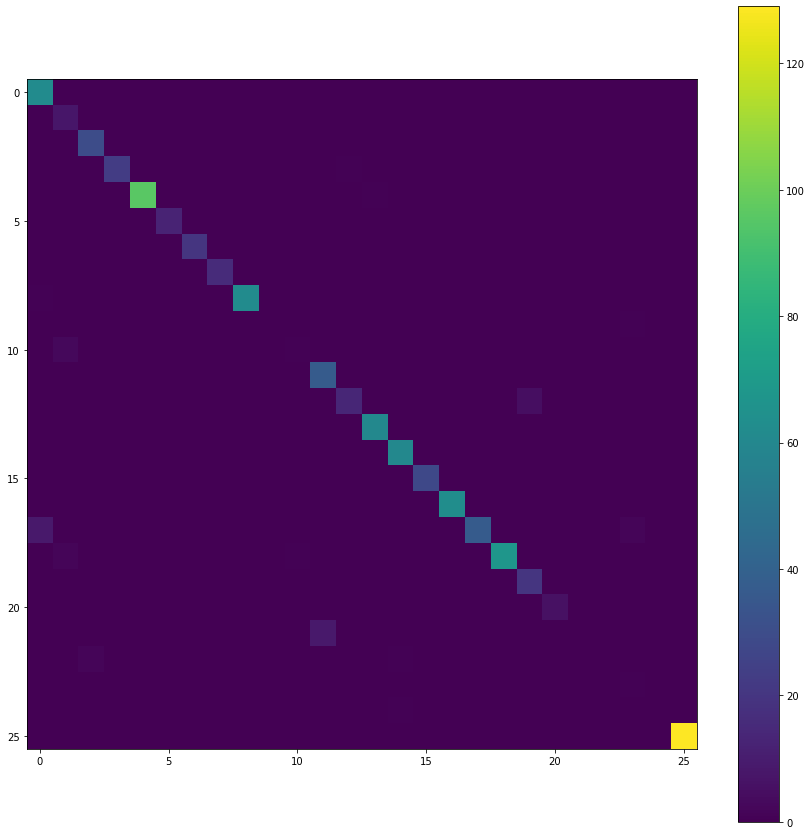

In [18]:
y_pred = model.predict(X_test)
matrix = tf.math.confusion_matrix(y_pred.argmax(axis=2)[:,0],y_test.argmax(axis=2)[:,0])

matrix = confusion_matrix(y_test.argmax(axis=2)[:,0], y_pred.argmax(axis=2)[:,0])

fig = plt.figure(figsize=(15, 15))
plt.imshow(matrix, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()
# print(classification_report(y_test.argmax(axis=2)[:,0], y_pred.argmax(axis=2)[:,0]))

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("morse_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8v841b8v/assets


INFO:tensorflow:Assets written to: /tmp/tmp8v841b8v/assets


355312

In [29]:
import subprocess
p_result = subprocess.run(["pip3", "freeze"], capture_output=True)
print(p_result.stdout)

b'absl-py==0.12.0\nalabaster==0.7.12\nalbumentations==0.1.12\naltair==4.1.0\nappdirs==1.4.4\nargon2-cffi==20.1.0\narviz==0.11.2\nastor==0.8.1\nastropy==4.2.1\nastunparse==1.6.3\nasync-generator==1.10\natari-py==0.2.9\natomicwrites==1.4.0\nattrs==21.2.0\naudioread==2.1.9\nautograd==1.3\nBabel==2.9.1\nbackcall==0.2.0\nbeautifulsoup4==4.6.3\nbleach==3.3.0\nblis==0.4.1\nbokeh==2.3.2\nBottleneck==1.3.2\nbranca==0.4.2\nbs4==0.0.1\nCacheControl==0.12.6\ncached-property==1.5.2\ncachetools==4.2.2\ncatalogue==1.0.0\ncertifi==2021.5.30\ncffi==1.14.5\ncftime==1.5.0\nchardet==3.0.4\nclick==7.1.2\ncloudpickle==1.3.0\ncmake==3.12.0\ncmdstanpy==0.9.5\ncolorcet==2.0.6\ncolorlover==0.3.0\ncommunity==1.0.0b1\ncontextlib2==0.5.5\nconvertdate==2.3.2\ncoverage==3.7.1\ncoveralls==0.5\ncrcmod==1.7\ncufflinks==0.17.3\ncvxopt==1.2.6\ncvxpy==1.0.31\ncycler==0.10.0\ncymem==2.0.5\nCython==0.29.23\ndaft==0.0.4\ndask==2.12.0\ndatascience==0.10.6\ndebugpy==1.0.0\ndecorator==4.4.2\ndefusedxml==0.7.1\ndescartes==1.1.0\

In [34]:

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Indicate that we want to perform the default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
#def representative_dataset_generator():
#  for value in X_test:
#    # Each scalar value must be inside of a 2D array that is wrapped in a list
#    yield [np.array(value, dtype=np.float32, ndmin=2)]
#converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("morse_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptg8953yv/assets


INFO:tensorflow:Assets written to: /tmp/tmptg8953yv/assets


101824

In [41]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('morse_model.tflite')
sine_model_quantized = tf.lite.Interpreter('morse_model_quantized.tflite')

# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# Get indexes of the input and output tensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = \
  sine_model_quantized.get_output_details()[0]["index"]

# Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

# Run each model's interpreter for each value and store the results in arrays
for x_value in X_test:
  # Create a 2D tensor wrapping the current x value
  #x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  x_value_tensor = tf.convert_to_tensor([x_value], dtype=np.float32)
  #x_value_tensor = x_value
  # Write the value to the input tensor
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  # Run inference
  sine_model.invoke()
  # Read the prediction from the output tensor
  sine_model_predictions.append(
      sine_model.get_tensor(sine_model_output_index)[0])
  # Do the same for the quantized model
  sine_model_quantized.set_tensor\
  (sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


#print("sine_model_predictions: ")
#print(sine_model_predictions)
#print("sine_model_quantized_predictions: ")
#print(sine_model_quantized_predictions)



# See how they line up with the data
#plt.clf()
#plt.title('Comparison of various models against actual values')
#plt.plot(X_test, Y_test, 'bo', label='Actual')
#plt.plot(X_test, predictions, 'ro', label='Original predictions')
#plt.plot(X_test, sine_model_predictions, 'bx', label='Lite predictions')
#plt.plot(X_test, sine_model_quantized_predictions, 'gx', \
#  label='Lite quantized predictions')
#plt.legend()
#plt.show()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
        0.04135701, 0.01453879, 0.0384326 , 0.03649536, 0.02193323,
        0.33800918]], dtype=float32), array([[0.09781167, 0.5845871 , 0.84832716, 0.1313366 , 0.17576215,
        0.6611564 , 0.69705284, 0.31609297, 0.0424329 , 0.02210993,
        0.1957117 , 0.31224298, 0.4563885 , 0.10089886, 0.99833995,
        0.47757128, 0.01514137, 0.21506307, 0.17522582, 0.16870624,
        0.5194962 , 0.17101783, 0.13444549, 0.8047904 , 0.50138146,
        0.7651394 , 0.05224317, 0.02223152, 0.03466189, 0.02841103,
        0.73758113]], dtype=float32), array([[0.29378527, 0.08363268, 0.84260225, 0.04615507, 0.5400912 ,
        0.29370174, 0.02442983, 0.26190287, 0.06458089, 0.00933966,
        0.21393701, 0.8021398 , 0.04904553, 0.01929837, 0.5534897 ,
        0.99195486, 0.00559059, 0.48950997, 0.21932551, 0.09652591,
        0.22042802, 0.53090674, 0.7804092 , 0.31890714, 0.4137669 ,
        0.3537442 , 0.00796574, 0.0297887

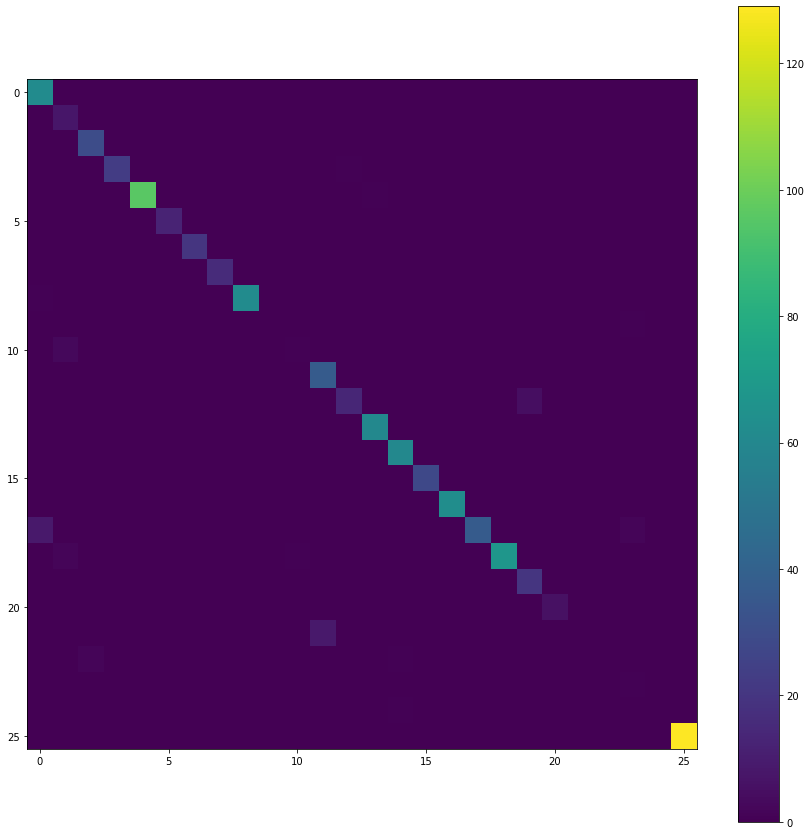

In [46]:
y_pred = np.array(sine_model_predictions, dtype=np.float32)
matrix = tf.math.confusion_matrix(y_pred.argmax(axis=2)[:,0],y_test.argmax(axis=2)[:,0])

matrix = confusion_matrix(y_test.argmax(axis=2)[:,0], y_pred.argmax(axis=2)[:,0])

fig = plt.figure(figsize=(15, 15))
plt.imshow(matrix, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()



# sine_model_predictions = []
# sine_model_quantized_predictions = []
# print(classification_report(y_test.argmax(axis=2)[:,0], y_pred.argmax(axis=2)[:,0]))

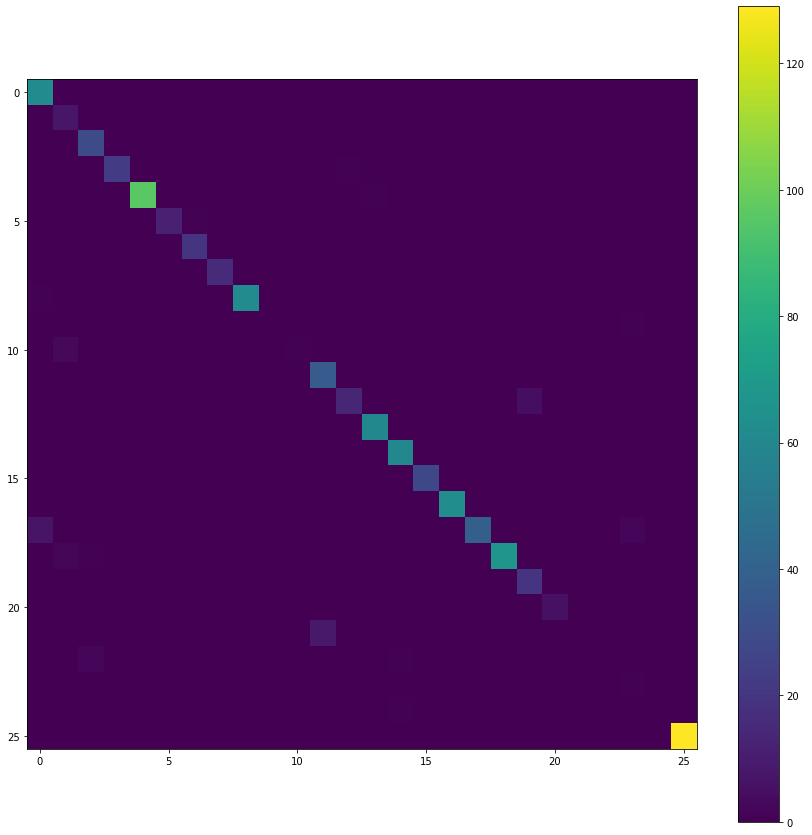

In [47]:
y_pred = np.array(sine_model_quantized_predictions, dtype=np.float32)
matrix = tf.math.confusion_matrix(y_pred.argmax(axis=2)[:,0],y_test.argmax(axis=2)[:,0])

matrix = confusion_matrix(y_test.argmax(axis=2)[:,0], y_pred.argmax(axis=2)[:,0])

fig = plt.figure(figsize=(15, 15))
plt.imshow(matrix, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()


In [43]:

print("X_test: ")
print(X_test)
print("Y_test: ")
print(y_test)

X_test: 
[[[158 158  91 ...   0   0   0]]

 [[ 91 159 159 ...   0   0   0]]

 [[139 159 159 ...   0   0   0]]

 ...

 [[ 92 159 129 ...   0   0   0]]

 [[151 161  94 ...   0   0   0]]

 [[ 94 162 144 ...   0   0   0]]]
Y_test: 
[[[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]]


In [52]:
p_result = subprocess.run("xxd -i morse_model_quantized.tflite > morse_model_quantized.cc", shell=True)
print(p_result.stdout)
#xxd_res = subprocess.run(["xxd"])
#print(xxd_res.stdout)

None


In [57]:
!apt-get -qq install xxd


Selecting previously unselected package xxd.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [60]:
!xxd -i morse_model.tflite > morse_model.cc
!xxd -i morse_model_quantized.tflite > morse_model_quantized.cc